In [1]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [29]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [30]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

train_fft = normalize_fft(train_fft)
test_fft = normalize_fft(test_fft)

1.0 0.0 (1+0j) (-0.35156567978155673-0.28484539037620443j)


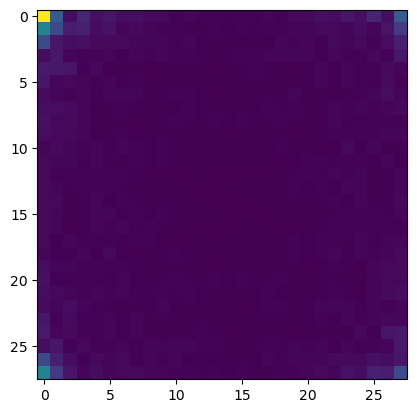

In [31]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [32]:
class CustomTransform:
    def __call__(self, sample):
        img, fft = sample
        # Duplicate the image along the channel dimension
        img_stacked = np.stack([img, img])
        
        # Split the complex FFT into real and imaginary parts
        fft_real = np.real(fft)
        fft_imag = np.imag(fft)
        fft_stacked = np.stack([fft_real, fft_imag])
        
        # Stack the image and FFT side by side
        combined = np.concatenate([img_stacked, fft_stacked], axis=2)
        
        return torch.from_numpy(combined).float()

In [33]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [34]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels) 

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [42]:
item = next(iter(train_loader))

torch.Size([64, 2, 28, 56])


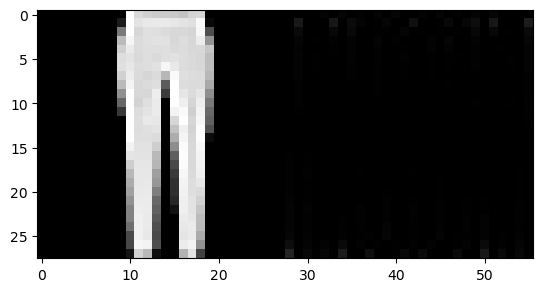

In [43]:
print(item[0].shape)
plt.imshow(item[0][0,1,:,:], cmap="gray", vmin=0, vmax=1)

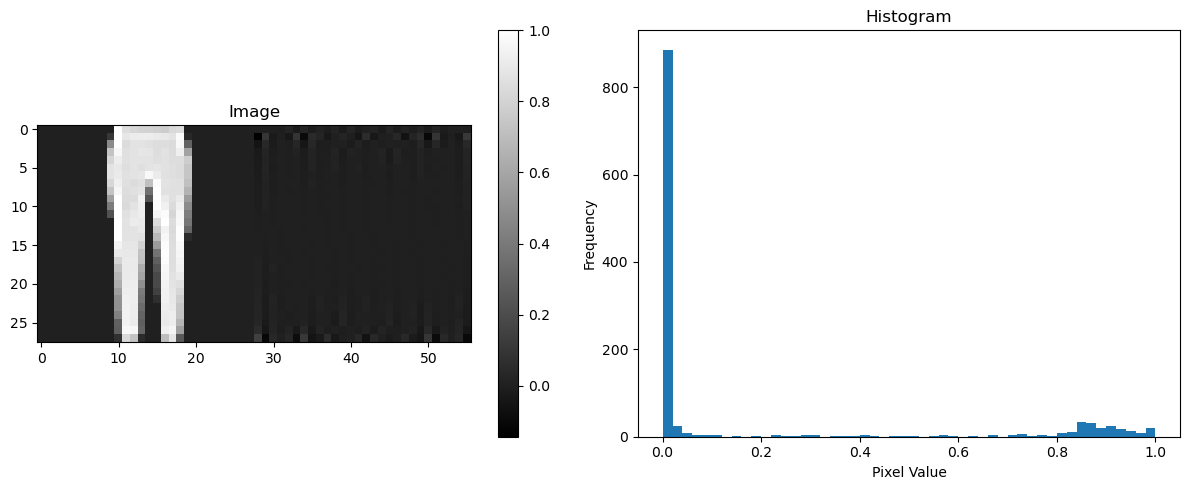

In [44]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [45]:
model = ViT(
    image_size = 56,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)

img = torch.randn(1, 2, 28, 56)

preds = model(img) # (1, 1000)

In [46]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6349774


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [48]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [50]:


model.to(device)
epochs = 500
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 1: 100%|██████████| 938/938 [01:15<00:00, 12.49batch/s, Train Loss=0.507, Train Acc=81.9]


Epoch 1
Train Loss: 0.5069, Train Accuracy: 81.89%
Test Loss: 0.3696, Test Accuracy: 86.47%



Epoch 2: 100%|██████████| 938/938 [01:16<00:00, 12.26batch/s, Train Loss=0.317, Train Acc=88.4]


Epoch 2
Train Loss: 0.3171, Train Accuracy: 88.35%
Test Loss: 0.3267, Test Accuracy: 88.03%



Epoch 3: 100%|██████████| 938/938 [01:16<00:00, 12.23batch/s, Train Loss=0.277, Train Acc=89.9]


Epoch 3
Train Loss: 0.2768, Train Accuracy: 89.92%
Test Loss: 0.3141, Test Accuracy: 88.76%



Epoch 4: 100%|██████████| 938/938 [01:16<00:00, 12.22batch/s, Train Loss=0.245, Train Acc=90.9]


Epoch 4
Train Loss: 0.2451, Train Accuracy: 90.95%
Test Loss: 0.3017, Test Accuracy: 89.09%



Epoch 5: 100%|██████████| 938/938 [01:16<00:00, 12.23batch/s, Train Loss=0.22, Train Acc=91.8] 


Epoch 5
Train Loss: 0.2201, Train Accuracy: 91.82%
Test Loss: 0.2998, Test Accuracy: 89.61%



Epoch 6: 100%|██████████| 938/938 [01:17<00:00, 12.18batch/s, Train Loss=0.199, Train Acc=92.5]


Epoch 6
Train Loss: 0.1992, Train Accuracy: 92.55%
Test Loss: 0.2898, Test Accuracy: 89.83%



Epoch 7: 100%|██████████| 938/938 [01:16<00:00, 12.25batch/s, Train Loss=0.177, Train Acc=93.4]


Epoch 7
Train Loss: 0.1773, Train Accuracy: 93.36%
Test Loss: 0.2852, Test Accuracy: 90.36%



Epoch 8: 100%|██████████| 938/938 [01:16<00:00, 12.30batch/s, Train Loss=0.16, Train Acc=94.1] 


Epoch 8
Train Loss: 0.1604, Train Accuracy: 94.06%
Test Loss: 0.3032, Test Accuracy: 90.08%



Epoch 9: 100%|██████████| 938/938 [01:16<00:00, 12.24batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 9
Train Loss: 0.1443, Train Accuracy: 94.49%
Test Loss: 0.3008, Test Accuracy: 90.10%



Epoch 10: 100%|██████████| 938/938 [01:16<00:00, 12.22batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 10
Train Loss: 0.1260, Train Accuracy: 95.31%
Test Loss: 0.3327, Test Accuracy: 89.64%



Epoch 11: 100%|██████████| 938/938 [01:16<00:00, 12.25batch/s, Train Loss=0.111, Train Acc=95.9]


Epoch 11
Train Loss: 0.1106, Train Accuracy: 95.86%
Test Loss: 0.3368, Test Accuracy: 90.30%



Epoch 12: 100%|██████████| 938/938 [01:17<00:00, 12.18batch/s, Train Loss=0.102, Train Acc=96.2] 


Epoch 12
Train Loss: 0.1020, Train Accuracy: 96.18%
Test Loss: 0.3454, Test Accuracy: 90.33%



Epoch 13:  98%|█████████▊| 916/938 [01:15<00:01, 12.16batch/s, Train Loss=0.0879, Train Acc=96.8]


KeyboardInterrupt: 